## Creating a User-level dataset for analysing user insights

This is a notebook started by Richie with the goal to pull data on individual subscribers. The goal is one row per subscriber, with info about them, like their gender, age, but also calculated values like average call duration and number of calls. This data can be used for all sorts of user analysis, including cluster analysis.

In [ ]:
import os
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np

In [ ]:
credential_path = "/viamo-datakind-19b12e3872f5.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path
Bigquery_client = bigquery.Client()



## Here is how I created the dataset

In [ ]:
user_data_base = pd.read_gbq('''select subscriber_id, 
            min(age) as age, 
            min(gender) as gender, 
            count(distinct(call_id)) as n_calls,
            count(distinct(block_theme)) as n_themes,
            count(distinct(block_topic)) as n_topics
    FROM `viamo-datakind.datadive.321_sessions_1122` 
    WHERE organization_country = 'Mali' 
    GROUP BY subscriber_id''')
print(user_data_base.shape)
print(user_data_base.describe().round(3))

(2341867, 6)
       subscriber_id      n_calls     n_themes     n_topics
count   2.341867e+06  2341867.000  2341867.000  2341867.000
mean    1.048648e+12       47.546        5.391        2.774
std     1.421819e+17      168.813        3.134        1.759
min     7.039976e+17        1.000        1.000        1.000
25%     1.047991e+18        3.000        2.000        1.000
50%     1.188158e+18        9.000        5.000        2.000
75%     1.303281e+18       31.000        8.000        4.000
max     1.441576e+18    14967.000       14.000       11.000


In [ ]:
median_calls_per_user = pd.read_gbq('''SELECT distinct(subscriber_id), 
PERCENTILE_CONT(duration_listened_seconds, 0.5) OVER(PARTITION BY subscriber_id) as median_call_duration
FROM `viamo-datakind.datadive.321_sessions_1122`
WHERE organization_country = 'Mali' 
''')
median_calls_per_user.head()

,subscriber_id,median_call_duration
0,939499770580885504,3.5
1,966658663257792512,43.0
2,968429792003678209,34.0
3,971855620947369984,23.5
4,972581424199163904,36.0


In [ ]:
user_data2 = user_data_base.merge(median_calls_per_user, on = 'subscriber_id', how = 'left')

In [ ]:
print(user_data2['gender'].unique())
print(user_data2['age'].unique())
print(user_data2['median_call_duration'].isna().mean())

['male' 'female' None]
['over_44' '25_34' None 'under_18' '18_24' '35_44']
0.010661151978314737


In [ ]:
user_data2['gender_numeric'] = user_data2['gender']\
    .replace(['male','female'], [1,2], inplace=False)\
        .fillna(-1)

user_data2['age_numeric'] = user_data2['age']\
    .replace(['under_18', '18_24','25_34','35_44','over_44'], [1, 2, 3, 4, 5], inplace=False)\
        .fillna(-1)

user_data2['median_call_duration']\
    .fillna(-1, inplace = True)

In [ ]:
fav_theme = pd.read_gbq('''with ordered_themes_by_users as (select subscriber_id, block_theme, ROW_NUMBER() OVER (PARTITION BY subscriber_id ORDER BY COUNT(block_theme) DESC) rn
FROM `viamo-datakind.datadive.321_sessions_1122`
WHERE organization_country = 'Mali'
group by subscriber_id, block_theme)
select subscriber_id, block_theme as fav_theme from ordered_themes_by_users where rn = 1
''')

second_fav_theme = pd.read_gbq('''with ordered_themes_by_users as (select subscriber_id, block_theme, ROW_NUMBER() OVER (PARTITION BY subscriber_id ORDER BY COUNT(block_theme) DESC) rn
FROM `viamo-datakind.datadive.321_sessions_1122`
WHERE organization_country = 'Mali'
group by subscriber_id, block_theme)
select subscriber_id, block_theme as second_fav_theme from ordered_themes_by_users where rn = 2
''')

In [ ]:
fav_topic = pd.read_gbq('''with ordered_topics_by_users as (select subscriber_id, block_topic, ROW_NUMBER() OVER (PARTITION BY subscriber_id ORDER BY COUNT(block_topic) DESC) rn
FROM `viamo-datakind.datadive.321_sessions_1122`
WHERE organization_country = 'Mali'
group by subscriber_id, block_topic)
select subscriber_id, block_topic as fav_topic from ordered_topics_by_users where rn = 1
''')

second_fav_topic = pd.read_gbq('''with ordered_topics_by_users as (select subscriber_id, block_topic, ROW_NUMBER() OVER (PARTITION BY subscriber_id ORDER BY COUNT(block_topic) DESC) rn
FROM `viamo-datakind.datadive.321_sessions_1122`
WHERE organization_country = 'Mali'
group by subscriber_id, block_topic)
select subscriber_id, block_topic as second_fav_topic from ordered_topics_by_users where rn = 2
''')

In [ ]:
user_data3 = user_data2\
.merge(fav_theme,           on = 'subscriber_id', how = 'left')\
.merge(second_fav_theme,    on = 'subscriber_id', how = 'left')\
.merge(fav_topic,           on = 'subscriber_id', how = 'left')\
.merge(second_fav_topic,    on = 'subscriber_id', how = 'left')

In [ ]:
user_data3['fav_theme'].unique()

array(['', 'news', 'health', 'gender', 'financial', 'ed',
       'health,nutrition', 'security', 'rights', 'ag'], dtype=object)

In [ ]:
print(user_data3['fav_theme'].unique())
print('\n')
print(user_data3['second_fav_theme'].unique())
print('\n')
print(user_data3['fav_topic'].unique())
print('\n')
print(user_data3['second_fav_topic'].unique())

['' 'news' 'health' 'gender' 'financial' 'ed' 'health,nutrition'
 'security' 'rights' 'ag']


['news' 'health' 'games' 'gender' 'health,nutrition' '' 'financial' nan
 'ed' 'security' 'rights' 'ag' 'financial,rights' 'nutrition']


['' 'livestock' 'environment' 'coronavirus,malaria' 'coronavirus'
 'malaria,ncd' 'coronavirus,malaria,ncd' 'malaria']


['coronavirus' 'coronavirus,malaria' 'livestock' 'gbv' 'malaria' nan ''
 'environment' 'malaria,ncd' 'coronavirus,malaria,ncd' 'maternal']


In [ ]:
# For Mali
user_data3['fav_theme_numeric'] = user_data3['fav_theme']\
    .replace(['', 'news','health','gender','financial','ed','health,nutrition','security','rights','ag'], [-1, 1, 2, 3, 4,5,6,7,8,9], inplace=False)\
        .fillna(-1)
user_data3['second_fav_theme_numeric'] = user_data3['second_fav_theme']\
    .replace(['', 'news','health','gender','financial','ed','health,nutrition','security','rights','ag','games','financial,rights','nutrition'], [-1, 1, 2, 3, 4,5,6,7,8,9,10,11,12], inplace=False)\
        .fillna(-1)

user_data3['fav_topic_numeric'] = user_data3['fav_topic']\
    .replace(['', 'livestock','environment','coronavirus,malaria','coronavirus','malaria,ncd','coronavirus,malaria,ncd','malaria'], [-1, 1, 2, 3, 4,5,6,7], inplace=False)\
        .fillna(-1)
user_data3['second_fav_topic_numeric'] = user_data3['second_fav_topic']\
    .replace(['', 'livestock','environment','coronavirus,malaria','coronavirus','malaria,ncd','coronavirus,malaria,ncd','malaria','gbv','maternal'], [-1, 1, 2, 3, 4,5,6,7,8,9], inplace=False)\
        .fillna(-1)

In [ ]:
# For Uganda
user_data3['fav_theme_numeric'] = user_data3['fav_theme']\
    .replace(['', 'weather','health','ag','vas','news','games','financial','drama'], [-1, 1, 2, 3, 4,5,6,7,8], inplace=False)\
        .fillna(-1)
user_data3['second_fav_theme_numeric'] = user_data3['second_fav_theme']\
    .replace(['', 'weather','health','ag','vas','news','games','financial','drama', 'gender','financial,games','ag,games'], [-1, 1, 2, 3, 4,5,6,7,8,9,10,11], inplace=False)\
        .fillna(-1)

user_data3['fav_topic_numeric'] = user_data3['fav_topic']\
    .replace(['', 'coronavirus','srh','beans','rice','maize','hiv,srh','cassava'], [-1, 1, 2, 3, 4,5,6,7], inplace=False)\
        .fillna(-1)
user_data3['second_fav_topic_numeric'] = user_data3['second_fav_topic']\
    .replace(['', 'coronavirus','srh','beans','rice','maize','hiv,srh','cassava','livestock','hiv'], [-1, 1, 2, 3, 4,5,6,7,8,9], inplace=False)\
        .fillna(-1)

In [ ]:
# For Nigeria TO DO
user_data3['fav_theme_numeric'] = user_data3['fav_theme']\
    .replace(['', 'weather','health','ag','vas','news','games','financial','drama'], [-1, 1, 2, 3, 4,5,6,7,8], inplace=False)\
        .fillna(-1)
user_data3['second_fav_theme_numeric'] = user_data3['second_fav_theme']\
    .replace(['', 'weather','health','ag','vas','news','games','financial','drama', 'gender','financial,games','ag,games'], [-1, 1, 2, 3, 4,5,6,7,8,9,10,11], inplace=False)\
        .fillna(-1)

user_data3['fav_topic_numeric'] = user_data3['fav_topic']\
    .replace(['', 'coronavirus','srh','beans','rice','maize','hiv,srh','cassava'], [-1, 1, 2, 3, 4,5,6,7], inplace=False)\
        .fillna(-1)
user_data3['second_fav_topic_numeric'] = user_data3['second_fav_topic']\
    .replace(['', 'coronavirus','srh','beans','rice','maize','hiv,srh','cassava','livestock','hiv'], [-1, 1, 2, 3, 4,5,6,7,8,9], inplace=False)\
        .fillna(-1)

In [ ]:
# user_data3.to_parquet('Viamo_user_data_Mali.parquet')

In [ ]:
user_data3

,subscriber_id,age,gender,n_calls,n_themes,n_topics,median_call_duration,gender_numeric,age_numeric,fav_theme,second_fav_theme,fav_topic,second_fav_topic,fav_theme_numeric,second_fav_theme_numeric,fav_topic_numeric,second_fav_topic_numeric
0,1057771709358727168,over_44,male,137,13,9,15.0,1.0,5.0,,news,,coronavirus,-1,5,-1,1
1,1258538143272463944,25_34,male,582,13,10,26.0,1.0,3.0,,health,,"coronavirus,malaria",-1,2,-1,"coronavirus,malaria"
2,968619422640562176,None,male,62,13,7,24.0,1.0,-1.0,,news,,"coronavirus,malaria",-1,5,-1,"coronavirus,malaria"
3,1066108357532246016,under_18,male,62,13,6,17.0,1.0,1.0,,health,,coronavirus,-1,2,-1,1
4,1192055677020335632,under_18,male,1447,13,9,6.0,1.0,1.0,,news,,coronavirus,-1,5,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2341862,1286423387992287036,18_24,male,377,12,4,10.0,1.0,2.0,,news,,"coronavirus,malaria",-1,5,-1,"coronavirus,malaria"
2341863,1022983498644381696,35_44,male,219,12,5,15.0,1.0,4.0,,news,,livestock,-1,5,-1,8
2341864,1007264149136793600,over_44,male,1708,12,9,3.0,1.0,5.0,,news,,coronavirus,-1,5,-1,1
2341865,1009919464248500224,35_44,male,216,12,4,19.0,1.0,4.0,,news,,"coronavirus,malaria",-1,5,-1,"coronavirus,malaria"


In [ ]:
type(user_data3[:5000].age[0])

str

In [ ]:
user_data3.age.replace('18_24', 21, inplace=True)
user_data3.age.replace('25_34', 30, inplace=True)
user_data3.age.replace('under_18', 15.5, inplace=True)
user_data3.age.replace('35_44', 40, inplace=True)
user_data3.age.replace('over_44', 50, inplace=True)

In [ ]:
user_data3.drop(columns=['gender'], inplace=True)

In [ ]:
user_data3

,subscriber_id,age,n_calls,n_themes,n_topics,median_call_duration,gender_numeric,age_numeric,fav_theme,second_fav_theme,fav_topic,second_fav_topic,fav_theme_numeric,second_fav_theme_numeric,fav_topic_numeric,second_fav_topic_numeric
0,1057771709358727168,50.0,137,13,9,15.0,1.0,5.0,,news,,coronavirus,-1,5,-1,1
1,1258538143272463944,30.0,582,13,10,26.0,1.0,3.0,,health,,"coronavirus,malaria",-1,2,-1,"coronavirus,malaria"
2,968619422640562176,NaN,62,13,7,24.0,1.0,-1.0,,news,,"coronavirus,malaria",-1,5,-1,"coronavirus,malaria"
3,1066108357532246016,15.5,62,13,6,17.0,1.0,1.0,,health,,coronavirus,-1,2,-1,1
4,1192055677020335632,15.5,1447,13,9,6.0,1.0,1.0,,news,,coronavirus,-1,5,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2341862,1286423387992287036,21.0,377,12,4,10.0,1.0,2.0,,news,,"coronavirus,malaria",-1,5,-1,"coronavirus,malaria"
2341863,1022983498644381696,40.0,219,12,5,15.0,1.0,4.0,,news,,livestock,-1,5,-1,8
2341864,1007264149136793600,50.0,1708,12,9,3.0,1.0,5.0,,news,,coronavirus,-1,5,-1,1
2341865,1009919464248500224,40.0,216,12,4,19.0,1.0,4.0,,news,,"coronavirus,malaria",-1,5,-1,"coronavirus,malaria"


In [ ]:
user_data3.drop(columns=['second_fav_topic'],inplace=True)

In [ ]:
user_data3.drop(columns=['second_fav_theme'], inplace=True)


In [ ]:
user_data3.drop(columns=['second_fav_topic_numeric'], inplace=True)

In [ ]:
user_data3.dropna(inplace=True)

In [ ]:
user_data3.drop(columns=['fav_theme'], inplace=True)
user_data3.drop(columns=['fav_topic'], inplace=True)

In [ ]:
user_data3.columns

Index(['subscriber_id', 'age', 'n_calls', 'n_themes', 'n_topics',
       'median_call_duration', 'gender_numeric', 'age_numeric',
       'fav_theme_numeric', 'second_fav_theme_numeric', 'fav_topic_numeric'],
      dtype='object')

In [ ]:
user_data3.fav_theme_numeric.value_counts()

-1                  1167494
5                      4415
2                      2704
gender                  178
health,nutrition         61
7                        20
ed                        9
security                  6
Name: fav_theme_numeric, dtype: int64

In [ ]:
user_data3['fav_theme_numeric'].replace('gender', 3, inplace=True)

In [ ]:
user_data3.fav_theme_numeric.replace('health,nutrition', 4, inplace=True)

In [ ]:
user_data3.fav_theme_numeric.replace('ed', 1, inplace=True)

In [ ]:
user_data3.fav_theme_numeric.replace('security', 6, inplace=True)

In [ ]:
user_data3.fav_theme_numeric.replace('rights', 7, inplace=True)

In [ ]:
user_data3.second_fav_theme_numeric.value_counts()

5                   842796
2                   205532
-1                   70483
9                    22375
health,nutrition      8746
7                     8238
ed                    6311
6                     5455
security              2511
rights                2025
3                      379
financial,rights        35
nutrition                1
Name: second_fav_theme_numeric, dtype: int64

In [ ]:
user_data3.second_fav_theme_numeric.replace('health,nutrition', 4, inplace=True)
user_data3.second_fav_theme_numeric.replace('ed', 1, inplace=True)
user_data3.second_fav_theme_numeric.replace('security', 6, inplace=True)
user_data3.second_fav_theme_numeric.replace('rights', 8, inplace=True)
user_data3.second_fav_theme_numeric.replace('financial,rights', 9, inplace=True)
user_data3.second_fav_theme_numeric.replace('nutrition', 10, inplace=True)

In [ ]:
user_data3.columns

Index(['subscriber_id', 'age', 'n_calls', 'n_themes', 'n_topics',
       'median_call_duration', 'gender_numeric', 'age_numeric',
       'fav_theme_numeric', 'second_fav_theme_numeric', 'fav_topic_numeric'],
      dtype='object')

In [ ]:
user_data3.fav_topic_numeric.value_counts()

-1                         1173658
1                              931
coronavirus,malaria            182
livestock                       86
malaria,ncd                     18
coronavirus,malaria,ncd          9
malaria                          2
environment                      1
Name: fav_topic_numeric, dtype: int64

In [ ]:
user_data3.fav_topic_numeric.replace('coronavirus,malaria', 2, inplace=True)
user_data3.fav_topic_numeric.replace('livestock', 3, inplace=True)
user_data3.fav_topic_numeric.replace('malaria,ncd', 4, inplace=True)
user_data3.fav_topic_numeric.replace('coronavirus,malaria,ncd', 7, inplace=True)
user_data3.fav_topic_numeric.replace('malaria', 5, inplace=True)
user_data3.fav_topic_numeric.replace('environment', 8, inplace=True)

In [ ]:
user_data3.shape

(1174887, 11)

In [ ]:
user_data3.drop(columns=['subscriber_id'], inplace=True)

In [ ]:
user_data3[:3500]

,age,n_calls,n_themes,n_topics,median_call_duration,gender_numeric,age_numeric,fav_theme_numeric,second_fav_theme_numeric,fav_topic_numeric
0,50.0,137,13,9,15.0,1.0,5.0,-1,5,-1
1,30.0,582,13,10,26.0,1.0,3.0,-1,2,-1
3,15.5,62,13,6,17.0,1.0,1.0,-1,2,-1
4,15.5,1447,13,9,6.0,1.0,1.0,-1,5,-1
5,15.5,77,13,6,13.0,1.0,1.0,-1,5,-1
...,...,...,...,...,...,...,...,...,...,...
7223,15.5,1,1,1,29.5,2.0,1.0,-1,-1,-1
7225,21.0,1,1,1,6.0,1.0,2.0,-1,-1,-1
7227,15.5,1,1,1,0.0,1.0,1.0,-1,-1,-1
7230,21.0,1,1,1,15.5,1.0,2.0,-1,-1,-1


In [ ]:
#Normalize data
from sklearn.preprocessing import normalize
data_scaled = normalize(user_data3[:10500])
data_scaled = pd.DataFrame(data_scaled, columns=user_data3.columns)
data_scaled.head()

,age,n_calls,n_themes,n_topics,median_call_duration,gender_numeric,age_numeric,fav_theme_numeric,second_fav_theme_numeric,fav_topic_numeric
0,0.338666,0.927945,0.088053,0.060960,0.101600,0.006773,0.033867,-0.006773,0.033867,-0.006773
1,0.051405,0.997264,0.022276,0.017135,0.044551,0.001714,0.005141,-0.001714,0.003427,-0.001714
2,0.228877,0.915509,0.191962,0.088598,0.251027,0.014766,0.014766,-0.014766,0.029533,-0.014766
3,0.010710,0.999867,0.008983,0.006219,0.004146,0.000691,0.000691,-0.000691,0.003455,-0.000691
4,0.191194,0.949803,0.160356,0.074011,0.160356,0.012335,0.012335,-0.012335,0.061676,-0.012335


In [ ]:
data_scaled.shape

(10500, 10)

In [ ]:
data_scaled.columns

Index(['age', 'n_calls', 'n_themes', 'n_topics', 'median_call_duration',
       'gender_numeric', 'age_numeric', 'fav_theme_numeric',
       'second_fav_theme_numeric', 'fav_topic_numeric'],
      dtype='object')

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(2)
 
# transform the data
X = pca.fit_transform(data_scaled)
 
X.shape

(10500, 2)

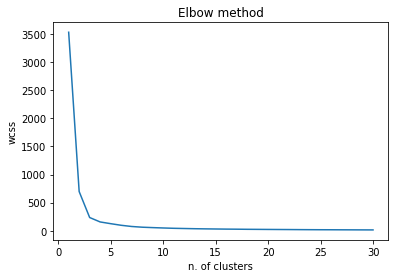

In [ ]:
from sklearn.cluster import KMeans
wcss=[]

for i in range(1,31):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,31), wcss)
plt.title('Elbow method')
plt.xlabel('n. of clusters')
plt.ylabel('wcss')
plt.show()

In [ ]:
# with k=7
kmeans = KMeans(n_clusters= 7)
 
# predict the labels of clusters
label = kmeans.fit_predict(X)
 
print(label)

[1 6 1 ... 3 3 2]


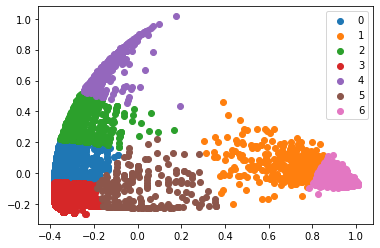

In [ ]:
# visualize clusters
 
u_labels = np.unique(label)
 
for i in u_labels:
    plt.scatter(X[label == i , 0] , X[label == i , 1] , label = i)
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaled_data=scaler.fit_transform(user_data3[:10500])

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(2)
 
# transform the data
X = pca.fit_transform(scaled_data)
 
X.shape

(10500, 2)

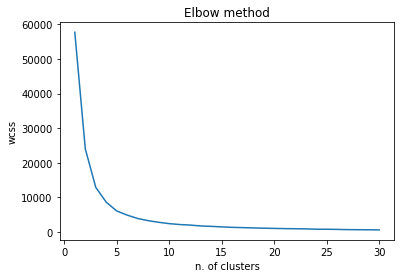

In [ ]:
from sklearn.cluster import KMeans
wcss=[]

for i in range(1,31):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,31), wcss)
plt.title('Elbow method')
plt.xlabel('n. of clusters')
plt.ylabel('wcss')
plt.show()

In [ ]:
# with k=7
kmeans = KMeans(n_clusters= 7)
 
# predict the labels of clusters
label = kmeans.fit_predict(X)
 
print(label)

[5 1 6 ... 4 2 3]


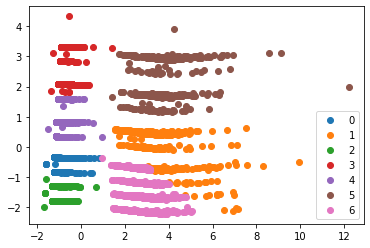

In [ ]:
# visualize clusters
 
u_labels = np.unique(label)
 
for i in u_labels:
    plt.scatter(X[label == i , 0] , X[label == i , 1] , label = i)
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
pca = PCA(2)
 
# transform the data
X = pca.fit_transform(data_scaled)
 
X.shape

(10500, 2)

In [ ]:
X

array([[ 0.72432693, -0.05422146],
       [ 0.97220907, -0.04330426],
       [ 0.78006278,  0.11874745],
       ...,
       [-0.36893816, -0.21815853],
       [-0.2963012 , -0.19756147],
       [-0.32528699,  0.32159696]])

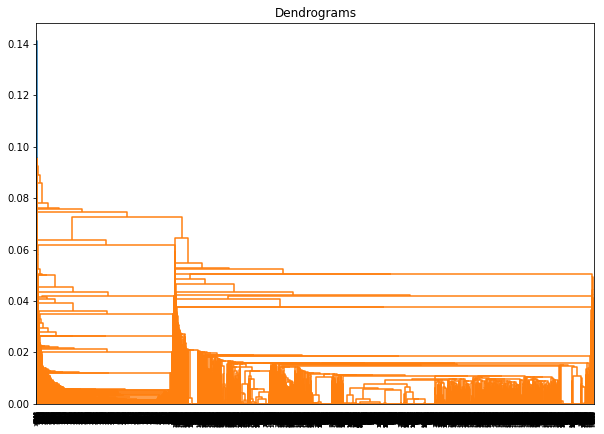

In [ ]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='single'))

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single').fit_predict(X)

In [ ]:
pd.Series(label).value_counts()

0    2619
2    2042
4    2018
6    1265
3    1231
1     805
5     520
dtype: int64

In [ ]:
pd.Series(clustering).value_counts()

0    10496
4        1
2        1
3        1
1        1
dtype: int64

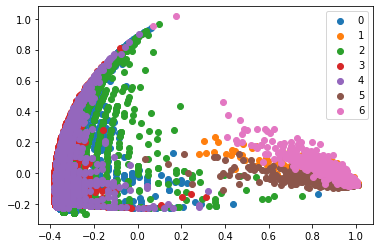

In [ ]:
u_labels = np.unique(label)
 
for i in u_labels:
    plt.scatter(X[label == i , 0] , X[label == i , 1] , label = i)
plt.legend()
plt.show()

In [ ]:
pd.Series(label).value_counts()

6    795
1    712
3    612
2    540
0    469
5    242
4    130
dtype: int64

In [ ]:
X

array([[ 0.72432693, -0.05422146],
       [ 0.97220907, -0.04330426],
       [ 0.78006278,  0.11874745],
       ...,
       [-0.36893816, -0.21815853],
       [-0.2963012 , -0.19756147],
       [-0.32528699,  0.32159696]])

In [ ]:
label

array([5, 1, 6, ..., 4, 2, 3], dtype=int32)

In [ ]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=.01)
db.fit(X)

DBSCAN(eps=0.01)

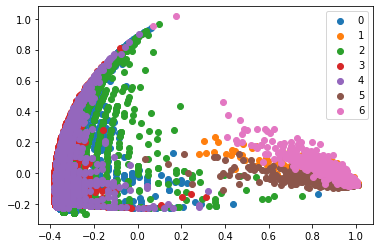

In [ ]:
u_labels = np.unique(label)
 
for i in u_labels:
    plt.scatter(X[label == i , 0] , X[label == i , 1] , label = i)
plt.legend()
plt.show()

In [ ]:
pd.Series(y_pred).value_counts()

In [ ]:
len(X)

10500

In [ ]:
interpret=user_data3[:10500]

In [ ]:
interpret['labels']=label

<ipython-input-164-749352917f98>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpret['labels']=label


In [ ]:
interpret.shape

(10500, 10)

In [ ]:
# FROM INTERPRETING THE RESULTS, IT LOOKS LIKE THE CLUSTERS ARE BROKEN DOWN BY AGE,
# AFTER AGE, THE CLUSTERS ARE BROKEN DOWN BY CALL_DURATION_MINUTES

In [ ]:
interpret[interpret.labels==0].median_call_duration.value_counts()

 0.0     969
-1.0     227
 5.0      74
 1.0      65
 3.0      62
        ... 
 27.5      1
 50.5      1
 40.0      1
 26.5      1
 36.5      1
Name: median_call_duration, Length: 105, dtype: int64

In [ ]:
interpret[interpret.labels==1].median_call_duration.value_counts()

16.0    65
17.0    64
15.0    52
12.0    45
9.0     42
18.0    40
19.0    40
8.0     37
6.0     37
10.0    35
4.0     35
7.0     33
5.0     33
14.0    33
13.0    32
11.0    32
20.0    29
21.0    23
3.0     19
25.0    14
23.0    14
22.0    12
26.0     8
24.0     7
2.0      4
29.0     2
17.5     2
19.5     2
27.0     2
50.0     2
32.0     1
16.5     1
55.0     1
22.5     1
8.5      1
14.5     1
31.0     1
52.0     1
44.0     1
30.0     1
Name: median_call_duration, dtype: int64

In [ ]:
#THIS SIMILAR CLUSTER IN AGE ARE BROKEN DOWN FURTHER BY N_CALLS (NOTICE THE DIFFERENCE BETWEEN THE TABLES)

In [ ]:
#AGE GROUP OF 15
interpret[interpret.labels==2]

,age,n_calls,n_themes,n_topics,median_call_duration,gender_numeric,age_numeric,fav_theme_numeric,second_fav_theme_numeric,fav_topic_numeric,labels
2935,15.5,1,1,1,13.0,1.0,1.0,-1,-1,-1,2
2937,15.5,4,1,1,7.0,2.0,1.0,-1,-1,-1,2
2999,15.5,5,1,1,3.5,1.0,1.0,-1,-1,-1,2
3010,15.5,2,1,1,24.0,2.0,1.0,-1,-1,-1,2
3018,15.5,4,1,1,0.0,1.0,1.0,-1,-1,-1,2
...,...,...,...,...,...,...,...,...,...,...,...
40826,15.5,1,1,1,54.0,1.0,1.0,-1,-1,-1,2
40839,15.5,2,1,2,19.0,2.0,1.0,-1,-1,-1,2
40863,15.5,2,1,1,0.0,1.0,1.0,-1,-1,-1,2
40905,15.5,1,1,1,50.5,2.0,1.0,-1,-1,-1,2


In [ ]:
#AGE GROUP OF 15
interpret[interpret.labels==6]

,age,n_calls,n_themes,n_topics,median_call_duration,gender_numeric,age_numeric,fav_theme_numeric,second_fav_theme_numeric,fav_topic_numeric,labels
3,15.5,62,13,6,17.0,1.0,1.0,-1,2,-1,6
4,15.5,1447,13,9,6.0,1.0,1.0,-1,5,-1,6
5,15.5,77,13,6,13.0,1.0,1.0,-1,5,-1,6
6,15.5,83,13,3,17.0,1.0,1.0,-1,5,-1,6
7,15.5,290,13,8,15.0,1.0,1.0,-1,5,-1,6
...,...,...,...,...,...,...,...,...,...,...,...
2896,21.0,62,13,4,15.0,1.0,2.0,-1,5,-1,6
2898,21.0,105,13,6,21.0,2.0,2.0,-1,5,-1,6
2903,15.5,99,13,8,14.0,2.0,1.0,-1,5,-1,6
18360,21.0,1,1,1,94.0,1.0,2.0,-1,-1,-1,6


In [ ]:
#THIS GROUPING IS ALSO THE SAME AGE BUT THE N_CALLS AND N_THEMES AND N_TOPICS ARE DIFFERENT SUGGESTING THAT 
#IN THE 40-50 AGE RANGE THERE ARE A GROUP THAT USE FREQUENTLY VS A GROUP THAT BARELY USES
interpret[interpret.labels==3]

,age,n_calls,n_themes,n_topics,median_call_duration,gender_numeric,age_numeric,fav_theme_numeric,second_fav_theme_numeric,fav_topic_numeric,labels
2925,40.0,1,1,1,0.0,1.0,4.0,-1,-1,-1,3
2954,50.0,1,1,1,-1.0,1.0,5.0,-1,-1,-1,3
3001,50.0,1,1,1,0.0,1.0,5.0,-1,-1,-1,3
3003,40.0,1,1,1,1.5,1.0,4.0,-1,-1,-1,3
3015,40.0,2,1,1,0.5,1.0,4.0,-1,-1,-1,3
...,...,...,...,...,...,...,...,...,...,...,...
40807,50.0,1,1,1,-1.0,1.0,5.0,-1,-1,-1,3
40812,50.0,1,1,1,0.0,2.0,5.0,-1,-1,-1,3
40832,50.0,3,1,1,10.0,1.0,5.0,-1,-1,-1,3
40846,50.0,1,1,1,-1.0,1.0,5.0,-1,-1,-1,3


In [ ]:
interpret[interpret.labels==5]

,age,n_calls,n_themes,n_topics,median_call_duration,gender_numeric,age_numeric,fav_theme_numeric,second_fav_theme_numeric,fav_topic_numeric,labels
0,50.0,137,13,9,15.0,1.0,5.0,-1,5,-1,5
10,50.0,653,13,7,9.0,2.0,5.0,-1,5,-1,5
15,40.0,1069,13,9,4.0,1.0,4.0,-1,5,-1,5
32,50.0,564,13,7,9.0,1.0,5.0,-1,5,-1,5
36,50.0,534,13,10,10.0,1.0,5.0,-1,5,-1,5
...,...,...,...,...,...,...,...,...,...,...,...
2891,40.0,174,13,5,7.0,1.0,4.0,-1,5,-1,5
2897,40.0,381,13,5,10.0,1.0,4.0,-1,5,-1,5
2899,40.0,181,13,6,23.0,1.0,4.0,-1,5,-1,5
2904,40.0,2068,13,9,16.0,1.0,4.0,-1,6,-1,5


In [ ]:
#THE 30 AGE RANGE IS A LONE GROUPING IN THIS ANALYSIS
interpret[interpret.labels==4]

,age,n_calls,n_themes,n_topics,median_call_duration,gender_numeric,age_numeric,fav_theme_numeric,second_fav_theme_numeric,fav_topic_numeric,labels
2946,30.0,1,1,1,10.5,1.0,3.0,-1,-1,-1,4
2955,30.0,2,1,1,30.0,1.0,3.0,-1,-1,-1,4
2972,30.0,1,1,1,1.5,1.0,3.0,-1,-1,-1,4
2975,30.0,11,1,1,5.0,1.0,3.0,-1,-1,-1,4
3037,30.0,1,1,1,-1.0,1.0,3.0,-1,-1,-1,4
...,...,...,...,...,...,...,...,...,...,...,...
40885,30.0,1,1,1,0.5,1.0,3.0,-1,-1,-1,4
40888,30.0,2,1,1,0.0,1.0,3.0,-1,-1,-1,4
40901,30.0,3,1,1,0.0,1.0,3.0,-1,-1,-1,4
40902,30.0,5,1,1,0.0,1.0,3.0,-1,-1,-1,4


,age,n_calls,n_themes,n_topics,median_call_duration,gender_numeric,age_numeric,fav_theme_numeric,second_fav_theme_numeric,fav_topic_numeric,labels
3,15.5,62,13,6,17.0,1.0,1.0,-1,2,-1,6
4,15.5,1447,13,9,6.0,1.0,1.0,-1,5,-1,6
5,15.5,77,13,6,13.0,1.0,1.0,-1,5,-1,6
6,15.5,83,13,3,17.0,1.0,1.0,-1,5,-1,6
7,15.5,290,13,8,15.0,1.0,1.0,-1,5,-1,6
...,...,...,...,...,...,...,...,...,...,...,...
2896,21.0,62,13,4,15.0,1.0,2.0,-1,5,-1,6
2898,21.0,105,13,6,21.0,2.0,2.0,-1,5,-1,6
2903,15.5,99,13,8,14.0,2.0,1.0,-1,5,-1,6
18360,21.0,1,1,1,94.0,1.0,2.0,-1,-1,-1,6


In [ ]:
### OVERALL ANALYSIS- BECAUSE OF THE DIFFERENCS IN AGE, CONCLUSION THAT AGE IS A CLUSTER FOLLOWED BY 
### USERS THAT USE PHONE FREQUENTLY AND (HENCE VARIED TOPICS, THEMES, CALLS) VS. USERS THAT USE THEIR PHONE
### INFREQUENTLY